#### load data


In [ ]:
import keras
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.madry_et_al import madry_et_al
from cleverhans.tf2.attacks.spsa import spsa
from cleverhans.tf2.attacks.momentum_iterative_method import momentum_iterative_method
from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2



import tensorflow as tf
import cleverhans
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from time import process_time

from helper.helper import *
from methods.deepfool import *
from methods.randomfuzz import *
from methods.pixelfuzz import * 

# loading the dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3) 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data
X_train /= 255
X_test /= 255



In [ ]:
# load the model Note that model2 is for comparing the transfer rate
# transfer rate of methdos from vgg16 to regularCNN is calculated in this file
model = keras.models.load_model("./Models/vgg16.h5")
model2 = keras.models.load_model("./Models/regular_cnn.h5")
# select number of tests for each attack methods. which is 50.
num_adversarials = 50
# results is a dictionary that maps "methodname" to tuple of 3()
# tuple[0] is the transfer rate
# tuple[1] is the np array containing the 50 distances from each adv image to orignal image
# tuple[2] is the np array containing the 50 runtimes consumed to generate each adv image
results = dict()
# some constant, as the data is normalized by /255, minimal stepsize should be multiple of 1/255
epsilon = 1/255

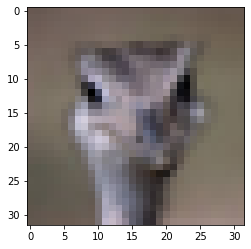

In [ ]:
# make a copy of the model
logits_model = tf.keras.Model(model.input,model.layers[-1].output)
# initialize the 2 lists
seed_images = []
seed_labels = []
i = 0
# loop until all 50 seed images that the model successfully classify are found
while i < (num_adversarials):
    # randomly select an image
    random_index = np.random.randint(X_test.shape[0])
    original_image = X_test[random_index]
    original_image = tf.convert_to_tensor(original_image.reshape(1,X_test.shape[1],X_test.shape[2],3), dtype=float) 
    original_label = y_test[random_index]
    predict_X = np.argmax(model.predict(original_image))
    # if the image is successfully classified, append this image to the list and record its label
    if (predict_X == original_label):
        seed_images.append(original_image)
        seed_labels.append(predict_X)
        i+=1
# plot the last image inserted to the list
plt.figure()
plt.grid(False)
image = seed_images[-1]
plt.imshow(np.reshape(image, (image.shape[1],image.shape[2],3)))
plt.show()

#### 1. DeepFool

In [ ]:
# test the Deepfool
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
# count the number of images model2 successfully recognizes
transfer_count = 0
# count the number of images model2 successfully classify and misclassify the adversarial image generated based on model1, 
transfer_adv_count = 0

# loop through the 50 selected original images
for i in  range(num_adversarials):
    # Note that deepfool guarantees the output is misclassified in one function call, thus no need to set up a loop to ensures misclassification
    # for measure run time.
    now = process_time()
    # call the deepfool function to generate adv image
    r, loop_i, label_orig, label_pert, adv_image = deepfool(seed_images[i], model)
    # clip the image to within the range
    adv_image = np.clip(adv_image,0,1)
    # update the runtime array at index
    times[i] += process_time()-now
    #  get and record the distance between the adv and original image
    distance[i] = float(tf.norm(seed_images[i] - adv_image, ord=2))
    # check if model2 can classify the original image
    if (np.argmax(model2.predict(seed_images[i])) == seed_labels[i]):
        transfer_count += 1
        # check if model2 misclassify the adv_image generated
        if (np.argmax(model2.predict(adv_image)) != seed_labels[i]):
            transfer_adv_count +=1
# save results into results dictionary
results["deepfool"] = (transfer_adv_count/ transfer_count, distance, times)


average distance 6.059909103438258
average runtime 0.325
transfer rate 0.5897435897435898


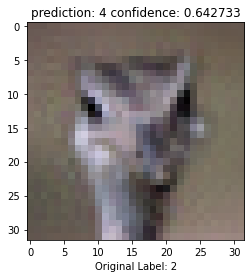

In [ ]:
# compute and print the results of the 50 samples
print("average distance", np.sum(results['deepfool'][1])/len(results['deepfool'][1]))
print("average runtime", np.sum(results['deepfool'][2])/len(results['deepfool'][2]))
print("transfer rate", results['deepfool'][0])
# draw the last image of the 50 selected images for comparison
draw(model,adv_image,seed_labels[-1])

#### 2. FGSM

In [ ]:
# test the FGSM
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
transfer_count = 0
transfer_adv_count = 0
# loop through the 50 selected sample original image
for i in  range (num_adversarials):
    # set up an loop that breaks when the model misclassify the generated image, 
    # this allows the generated image keeps moving away from the original image untill misclassification and 
    # guarantees the generated image is an adversarial image
    # Note that many methods dont requires this loop to generate adversarial image (i.e. adv image is found in one iteration)
    # this function is just a "guarantee" 
    image = seed_images[i]
    while(1):
        # for recording the time consumption
        now = process_time()
        # generate the adv_image based on the old image, in one function call to the fgsm method.
        # Note that L2 norm is used, and stepsize of epsilon*50 (which is 50/255) is allowed for one function call, 
        # this step size of 50/255 will remains the same for the other methods that have this parameter
        adv_image = fast_gradient_method(logits_model,  image, epsilon*50, norm=2, targeted=False, clip_max=1, clip_min = 0)
        # update the time consumption
        times[i]+=process_time()-now
        # get the prediction this model makes
        prediction = np.argmax(model.predict(adv_image))
        # update the generated image
        image = adv_image
        # if the model misclassify, break the loop and move to next original image
        if prediction != seed_labels[i]:
            # updates/calculates the transfer rate
            if (np.argmax(model2.predict(seed_images[i])) == seed_labels[i]):
                transfer_count += 1
                if (np.argmax(model2.predict(adv_image)) != seed_labels[i]):
                    transfer_adv_count +=1
            # record the distance from generated image to original image
            distance[i] = float(tf.norm(seed_images[i] - image, ord=2))
            break
# record the results
results["fgsm"] = (transfer_adv_count/ transfer_count, distance, times)


average distance 0.2779144409298897
average runtime 0.0396875
transfer rate 0.125


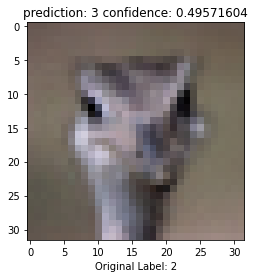

In [ ]:
print("average distance", np.sum(results['fgsm'][1])/len(results['fgsm'][1]))
print("average runtime", np.sum(results['fgsm'][2])/len(results['fgsm'][2]))
print("transfer rate", results['fgsm'][0])
draw(model,adv_image,seed_labels[-1])

#### 3. BIM

In [ ]:
# test the BIM
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
transfer_count = 0
transfer_adv_count = 0
# same setup as fgsm
for i in  range (num_adversarials):
    image = seed_images[i]
    while(1):
        now = process_time()
        # function call to BIM, also note that L2norm and 50/255 max distance per function call is selected as well
        adv_image = basic_iterative_method(logits_model, image, eps = epsilon*50,eps_iter=epsilon,nb_iter=50, norm=2, clip_max=1, clip_min = 0,sanity_checks=False)
        times[i]+=process_time()-now
        prediction = np.argmax(model.predict(adv_image))
        image = adv_image
        if prediction != seed_labels[i]:
            if (np.argmax(model2.predict(seed_images[i])) == seed_labels[i]):
                transfer_count += 1
                if (np.argmax(model2.predict(adv_image)) != seed_labels[i]):
                    transfer_adv_count +=1
            distance[i] = float(tf.norm(seed_images[i] - image, ord=2))
            break
results["bim"] = (transfer_adv_count/ transfer_count, distance, times)

average distance 0.22963588505983354
average runtime 0.41375
transfer rate 0.15


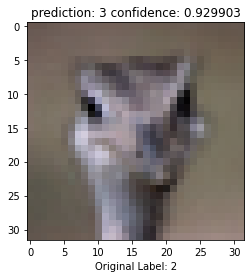

In [ ]:
print("average distance", np.sum(results['bim'][1])/len(results['bim'][1]))
print("average runtime", np.sum(results['bim'][2])/len(results['bim'][2]))
print("transfer rate", results['bim'][0])
draw(model,adv_image,seed_labels[-1])

#### 4.madry

In [ ]:
# test the madry
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
transfer_count = 0
transfer_adv_count = 0
# same setup as fgsm
for i in  range (num_adversarials):
    image = seed_images[i]
    while(1):
        now = process_time()
        # function call to madry's method
        adv_image = madry_et_al(logits_model, image, eps = epsilon*50,eps_iter=epsilon,nb_iter=50, norm=2, clip_max=1, clip_min = 0,sanity_checks=False)
        times[i]+=process_time()-now
        prediction = np.argmax(model.predict(adv_image))
        image = adv_image
        if prediction != seed_labels[i]:
            if (np.argmax(model2.predict(seed_images[i])) == seed_labels[i]):
                transfer_count += 1
                if (np.argmax(model2.predict(adv_image)) != seed_labels[i]):
                    transfer_adv_count +=1
            distance[i] = float(tf.norm(seed_images[i] - image, ord=2))
            break
results["madry"] = (transfer_adv_count/ transfer_count, distance, times)

average distance 0.26143369674682615
average runtime 0.46625
transfer rate 0.075


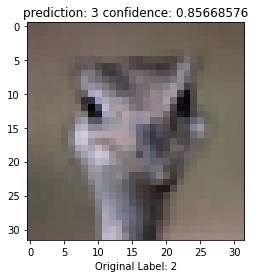

In [ ]:
print("average distance", np.sum(results['madry'][1])/len(results['madry'][1]))
print("average runtime", np.sum(results['madry'][2])/len(results['madry'][2]))
print("transfer rate", results['madry'][0])
draw(model,adv_image,seed_labels[-1])

#### 5. random fuzz

In [ ]:
# test the random fuzzer
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
transfer_count = 0
transfer_adv_count = 0
# same set up as fgsm
for i in  range (num_adversarials):
    image = seed_images[i]
    # start recording process time, unlike fgsm, the time to check misclassification is also included
    # as this is an important and time consuming step in the algorithm 
    now = process_time()
    # Note this loop also performs "generate_adversarial" function as the report mentions.
    while(1):
        # function call to the fuzz step function. 
        adv_image = random_fuzz(image, epsilon*5)
        prediction = np.argmax(model.predict(adv_image))
        image = adv_image
        # when prediction is found, record the time and distance, everything else is the same as fgsm
        if prediction != seed_labels[i]:
            d = float(tf.norm(seed_images[i] - image, ord=2))
            times[i]+=process_time()-now
            if (np.argmax(model2.predict(seed_images[i])) == seed_labels[i]):
                transfer_count += 1
                if (np.argmax(model2.predict(adv_image)) != seed_labels[i]):
                    transfer_adv_count +=1
            distance [i] = d
            break
results["randomfuzz"] = (transfer_adv_count/ transfer_count, distance, times)

average distance 4.34182297706604
average runtime 3.2425
transfer rate 0.7


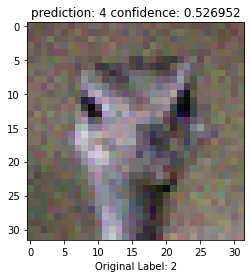

In [ ]:
print("average distance", np.sum(results['randomfuzz'][1])/len(results['randomfuzz'][1]))
print("average runtime", np.sum(results['randomfuzz'][2])/len(results['randomfuzz'][2]))
print("transfer rate", results['randomfuzz'][0])
draw(model,adv_image,seed_labels[-1])

#### 6. MIM (momentum iterative method)

In [ ]:
# test the MIM
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
transfer_count = 0
transfer_adv_count = 0
# same set up as fgsm
for i in  range (num_adversarials):
    image = seed_images[i]
    while(1):
        now = process_time()
        # different function call to MIM method
        adv_image = momentum_iterative_method(logits_model, image, norm=2, clip_max=1, clip_min = 0,sanity_checks=False)
        times[i]+=process_time()-now
        prediction = np.argmax(model.predict(adv_image))
        image = adv_image
        if prediction != seed_labels[i]:
            if (np.argmax(model2.predict(seed_images[i])) == seed_labels[i]):
                transfer_count += 1
                if (np.argmax(model2.predict(adv_image)) != seed_labels[i]):
                    transfer_adv_count +=1
            distance[i] = float(tf.norm(seed_images[i] - image, ord=2))
            break
results["MIM"] = (transfer_adv_count/ transfer_count, distance, times)

average distance 0.33335193037986754
average runtime 0.0965625
transfer rate 0.2


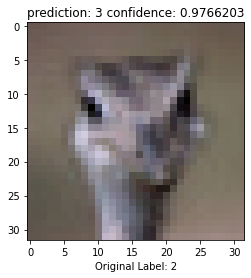

In [ ]:
print("average distance", np.sum(results['MIM'][1])/len(results['MIM'][1]))
print("average runtime", np.sum(results['MIM'][2])/len(results['MIM'][2]))
print("transfer rate", results['MIM'][0])
draw(model,adv_image,seed_labels[-1])

#### 7. SPSA

In [ ]:
# SPSA
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
transfer_count = 0
transfer_adv_count = 0
# same set up as fgsm
for i in  range (num_adversarials):
    image = seed_images[i]
    while(1):
        now = process_time()
        # calls the spsa
        adv_image = spsa(logits_model, image, seed_labels[i],epsilon, 50, clip_max=1, clip_min = 0)
        times[i]+=process_time()-now
        prediction = np.argmax(model.predict(adv_image))
        image = adv_image
        if prediction != seed_labels[i]:
            if (np.argmax(model2.predict(seed_images[i])) == seed_labels[i]):
                transfer_count += 1
                if (np.argmax(model2.predict(adv_image)) != seed_labels[i]):
                    transfer_adv_count +=1
            distance[i] = float(tf.norm(seed_images[i] - image, ord=2))
            break
results["SPSA"] = (transfer_adv_count/ transfer_count, distance, times)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


c:\users\victiny\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


average distance 0.3207254046201706
average runtime 1.885625
transfer rate 0.075


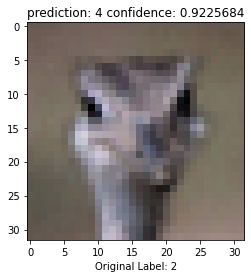

In [ ]:
print("average distance", np.sum(results['SPSA'][1])/len(results['SPSA'][1]))
print("average runtime", np.sum(results['SPSA'][2])/len(results['SPSA'][2]))
print("transfer rate", results['SPSA'][0])
draw(model,adv_image,seed_labels[-1])

#### 8. Carlini Wagner

In [ ]:
# test carlini wagner
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
transfer_count = 0
transfer_adv_count = 0
# same set up as fgsm
for i in  range (num_adversarials):
    image = seed_images[i]
    while(1):
        now = process_time()
        # function call to C&W's method
        adv_image = carlini_wagner_l2(logits_model, image)
        times[i]+=process_time()-now
        prediction = np.argmax(model.predict(adv_image))
        image = adv_image
        if prediction != seed_labels[i]:
            if (np.argmax(model2.predict(seed_images[i])) == seed_labels[i]):
                transfer_count += 1
                if (np.argmax(model2.predict(adv_image)) != seed_labels[i]):
                    transfer_adv_count +=1
            distance[i] = float(tf.norm(seed_images[i] - image, ord=2))
            break
results["CW"] = (transfer_adv_count/ transfer_count, distance, times)


average distance 0.15645855210721493
average runtime 41.6784375
transfer rate 0.05


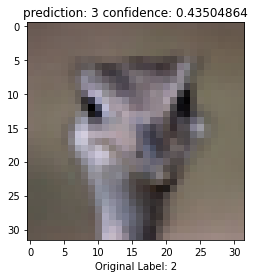

In [ ]:
print("average distance", np.sum(results['CW'][1])/len(results['CW'][1]))
print("average runtime", np.sum(results['CW'][2])/len(results['CW'][2]))
print("transfer rate", results['CW'][0])
draw(model,adv_image,seed_labels[-1])

#### 9. Pixel fuzz

In [ ]:
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
transfer_count = 0
transfer_adv_count = 0
# same setup as random fuzz
for i in  range (num_adversarials):
    image = seed_images[i]
    now = process_time()
    while(1):
        # function call to pixel fuzz fuzz step. 
        adv_image = pixel_fuzz(logits_model, image, epsilon*5, num_pixels = 10)
        prediction = np.argmax(model.predict(adv_image))
        image = adv_image
        if prediction != seed_labels[i]:
            d = float(tf.norm(seed_images[i] - image, ord=2))
            # additional step that checks if distance is small enough, 
            if d<=1.5:
                # record runtime and distance
                times[i]+=process_time()-now
                if (np.argmax(model2.predict(seed_images[i])) == seed_labels[i]):
                    transfer_count += 1
                    if (np.argmax(model2.predict(adv_image)) != seed_labels[i]):
                        transfer_adv_count +=1
                distance [i] = d
                break
            # if distance is too large, print the index and distance
            print(d,i)
results["pixelfuzz"] = (transfer_adv_count/ transfer_count, distance, times)

In [ ]:
# additional code block to measure the number of pixels modified
# record the total number of rgb values modified
num_rbg_modified = 0
for i in  range (num_adversarials):
    image = seed_images[i]
    while(1):
        adv_image = pixel_fuzz(logits_model, image, epsilon*5, num_pixels = 10)
        prediction = np.argmax(model.predict(adv_image))
        # replace the image with the generated adversarial image
        image = adv_image
        if prediction != seed_labels[i]:
            # record the number of rgb values modified
            num_rbg_modified += np.count_nonzero(adv_image-seed_images[i])
            break
# 3 rbg values per pixel. thus divide by 3, print the average pixels modified for each image
print("the average pixels modified are:", num_rbg_modified/num_adversarials/3)

the average pixels modified are: 56.71333333333333


average distance 0.35584185674786567
average runtime 1.1390625
transfer rate 0.1


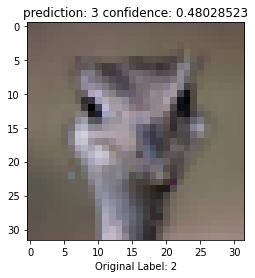

In [ ]:
print("average distance", np.sum(results['pixelfuzz'][1])/len(results['pixelfuzz'][1]))
print("average runtime", np.sum(results['pixelfuzz'][2])/len(results['pixelfuzz'][2]))
print("transfer rate", results['pixelfuzz'][0])
draw(model,adv_image,seed_labels[-1])

### save the results

In [ ]:
save_obj(results,"vgg16stats")
